In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import random
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
np.random.seed(25)

In [4]:
######### VGG19 parameters ########
dontFreezeLast = 2;

patience = 30;

loadWeights = False;
saveWeights = False;


tensorboard_dir = '../tb/mnist/try0';
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)    
checkPointPath = tensorboard_dir + '/best_weights.hdf5';

####################################

gpuName = '/device:GPU:1'
tensorboardFlag = True;
workers = 10;
histogram_freq = 0;

batchSize = 64;
epochs = 100;
validation_size=0.3;

In [5]:
df_train = pd.read_csv('../input/labels.csv')
df_test = pd.read_csv('../input/sample_submission.csv')

print('Training images: ',df_train.shape[0])
print('Test images: ',df_test.shape[0])

('Training images: ', 10222)
('Test images: ', 10357)


In [6]:
df_train.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [7]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [8]:
one_hot_labels = np.asarray(one_hot)
im_size = 90
x_train = []
y_train = []
x_test = []

In [9]:
i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread('../input/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

100%|██████████| 10222/10222 [00:49<00:00, 205.61it/s]


Text(0.5,1,u'Class [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0]')

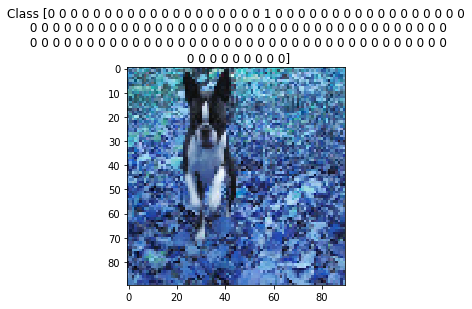

In [11]:
plt.imshow(x_train[0], cmap='gray')
plt.title('Class '+ str(y_train[0]))

In [19]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

#x_train.shape

In [20]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
#Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0], dtype=uint8),
 array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]]))

In [21]:
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 10, 64)        0         
__________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
train_generator = gen.flow(X_train, Y_train, batch_size=64)
#test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

In [ ]:
# model.fit(X_train, Y_train, batch_size=128, nb_epoch=1, validation_data=(X_test, Y_test))

model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs, 
                    validation_data=test_generator, validation_steps=10000//64)

In [ ]:
score = model.evaluate(X_test)
print()
print('Test accuracy: ', score[1])

In [ ]:
#predictions = model.predict_classes(X_test)

#predictions = list(predictions)
#actuals = list(y_test)

#sub = pd.DataFrame({'Actual': actuals, 'Predictions': predictions})
#sub.to_csv('./output_cnn.csv', index=False)

# Pseudo Labelling

In [ ]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.N = sum([it.n for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [ ]:
predictions = model.predict(X_test, batch_size=64)

predictions[:5]

In [ ]:
# gen = ImageDataGenerator()

batches = gen.flow(X_train, Y_train, batch_size=48)
test_batches = test_gen.flow(X_test, predictions, batch_size=16)

In [ ]:
mi = MixIterator([batches, test_batches])

mi.N

In [ ]:
model.fit_generator(mi, steps_per_epoch=mi.N//64, epochs=5, validation_data=(X_test, Y_test))